In [199]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import tensorflow as tf
plt.style.use("ggplot")


from tensorflow.keras.layers import Dense, Input, Concatenate, BatchNormalization

from tensorflow.keras import Model

+ https://ipythonquant.wordpress.com/2018/06/01/pricing-bermudan-options-in-tensorflow-learning-an-optimal-early-exercise-strategy/

+ https://github.com/pooyasf/DGM
+ https://www.tensorflow.org/addons/api_docs/python/tfa/image/interpolate_spline
+ https://www.tensorflow.org/graphics/api_docs/python/tfg/math/interpolation/bspline/interpolate


$$V_{\sigma^{2} t} + \frac{\sigma^{2}s^{2}}{2}V_{ss} = 0$$

$$\frac{V_{n + 1, m} - V_{n, m}}{\Delta t} + s_{m}^{2}\frac{V_{n, m + 1} - 2V_{n, m } + V_{n, m + 1}}{\Delta x^{2}} = 0$$

In [293]:
N, M = 32, 256
S_range = np.linspace(np.min(Sts), np.max(Sts), N)
T_range = np.linspace(np.min(sigma_t ** 2), np.max(sigma_t ** 2), M)

dt = np.diff(T_range)[0]
dx = np.diff(S_range)[0]

grid = np.zeros((N, M))
grid[:, -1] = np.maximum(1.0 - S_range, 0)

for j in range(M - 2, -1, -1):
    grid[1:-1, j] = grid[1:-1, j + 1] + 0.5 * (dt / (dx ** 2)) * ((S_range[1:-1] ** 2) * (grid[:-2, j + 1] - 2 * grid[1:-1, j + 1] + grid[2:, j + 1]))

    grid[0, j] = 1.0 - S_range[0]
    grid[-1, j] = 0.0
    grid[:, j] = np.maximum(grid[:, j], np.maximum(1.0 - S_range, 0))

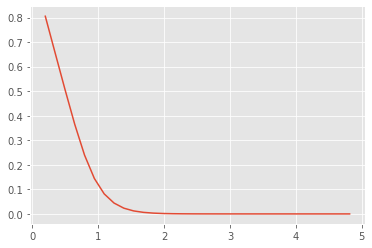

In [298]:
plt.plot(S_range, grid[:, 0])

In [214]:
N_SAMPLES, N_TIMES = 10000, 16
SEED = 42
rng = default_rng(SEED)
Zs = rng.standard_normal((N_SAMPLES, N_TIMES))

T = 1
dt = T / N_TIMES

ts = np.linspace(dt, T, N_TIMES).reshape((1, -1))
SK = np.linspace(0.25, 2, N_SAMPLES).reshape((-1, 1))
sigma = np.linspace(0.1, 0.3, N_SAMPLES).reshape((-1, 1))
Sts = SK * np.exp(-0.5 * ts * sigma ** 2 + sigma * np.sqrt(dt) * np.cumsum(Zs, axis = 1))
sigma_t = sigma * np.sqrt(T - ts)

input_m = Input(1)
input_t = Input(1)
x = Concatenate()([input_m, input_t])
x = BatchNormalization()(x)
x = Dense(100, activation='relu', kernel_initializer='glorot_uniform')(x)
output_layer = Dense(1, kernel_initializer='glorot_uniform')(x)
model = Model([input_m, input_t], output_layer)

Sts = Sts.astype(np.float32)
sigma_t = sigma_t.astype(np.float32)
X1 = tf.Variable(Sts)
X2 = tf.Variable(sigma_t)
y = np.maximum(1.0 - Sts[:,-1], 0).astype(np.float32)

loss_fn = tf.keras.losses.MeanSquaredError()

from tensorflow.keras.optimizers import Adam
lr = 1e-3
opt = Adam(learning_rate = lr)

EPOCHS = 100
from tqdm import tqdm
losses = []

model.compile(optimizer='Adam', loss = 'MSE')
model.fit([X1[:,-2], X2[:, -2]], y, epochs=100)

Epoch 1/100
313/313 [==============================] - 1s 1ms/step - loss: 0.0064
Epoch 2/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 3/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 4/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 5/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 6/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 7/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 8/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 9/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 10/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 11/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 12/100
313/313 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 13/100


In [219]:
for j in range(N_TIMES - 3, -1, -1):
    for i in tqdm(range(EPOCHS)):
        with tf.GradientTape(persistent=True) as tape:
            output = model([X1[:,j], X2[:, j]])
            loss = loss_fn(output[:,0], y)
            model_grad = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(model_grad, model.trainable_variables))
        losses += [loss.numpy()]
    y = tf.math.maximum(output[:,0], tf.math.maximum(1.0 - X1[:,j], 0))
        


    

  0%|                                                   | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 60.86it/s]


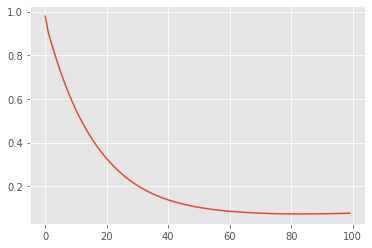

In [211]:
plt.plot(losses)

In [209]:
np.mean((output[:,0] - y) ** 2)

1.5153917

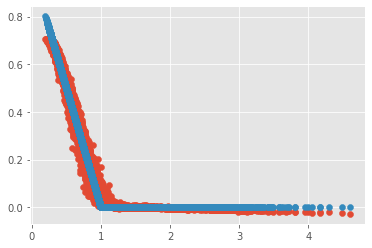

In [218]:
output = model([X1[:,-2], X2[:, -2]])
plt.scatter(X1[:, 15], output)
plt.scatter(X1[:, 15], y)

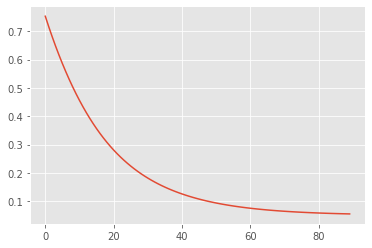

In [183]:
plt.plot(losses[10:])

In [138]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

ys = np.zeros((N_SAMPLES, N_TIMES))
ys[:, -1] = np.maximum(1.0 - Sts[:,-1], 0).astype(np.float32)

lrs = {}
for i in range(N_TIMES - 2, -1, -1):
    X = np.vstack([Sts[:,i], sigma_t[:, i]]).T
    X2 = PolynomialFeatures().fit_transform(X)
    lrs[i] = LinearRegression().fit(X, ys[:, i + 1])
    output = lrs[i].predict(X)
    ys[:, i] = np.maximum(output, np.maximum(1.0 - Sts[:,i], 0))

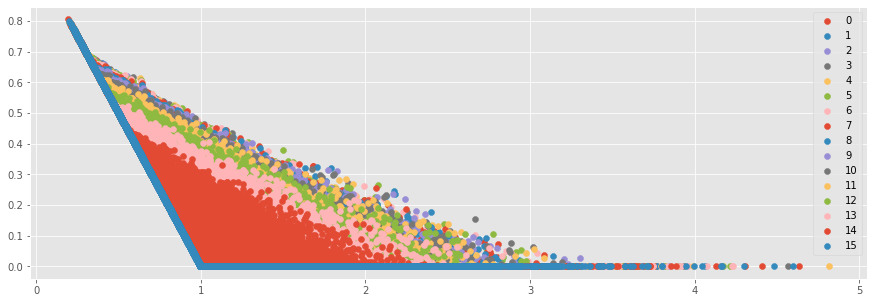

In [147]:
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(N_TIMES):
    ax.scatter(Sts[:,i], ys[:,i], label=f"{i}")
    
ax.legend()

<AxesSubplot:>

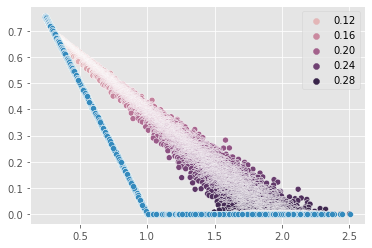

In [155]:
sns.scatterplot(x = Sts[:,0], y = ys[:,0], hue = sigma_t[:,0])
sns.scatterplot(x = Sts[:,0], y = np.maximum(1.0 - Sts[:,0], 0))

In [175]:
np.mean((preds[:,0] - np.maximum(1.0 - X1[:, -1], 0)) ** 2)

0.41937432

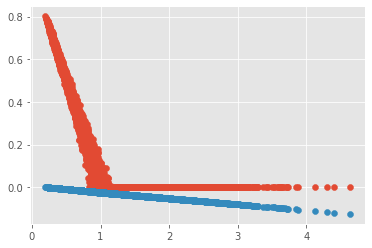

In [198]:
preds = model([X1[:,-2], X2[:,-2]])
plt.scatter(X1[:, -2], np.maximum(1.0 - X1[:,-1], 0))
plt.scatter(X1[:, -2], preds.numpy().reshape(-1))

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

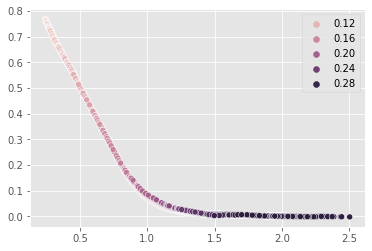

In [222]:
preds = model([X1[:,0], X2[:,0]])
sns.scatterplot(X1[:, 0], preds.numpy().reshape(-1), hue = X2[:,0])

In [ ]:
t